In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from pathlib import Path
import numpy as np
from astropy.io import fits
from astropy.table import Table
from matplotlib import pyplot as plt
from kspecdr.inst.isoplane import convert_isoplane_header, add_fiber_table
from kspecdr.io.image import ImageFile
from kspecdr.preproc.make_im import make_im
from kspecdr.preproc.preproc import reduce_bias, reduce_dark
from kspecdr.tlm.make_tlm import read_instrument_data, make_tlm
from scipy.signal import find_peaks_cwt, find_peaks
from rascal.util import refine_peaks
from matplotlib.lines import Line2D
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(name)s | %(levelname)s | %(message)s"
    )

WD = Path("/data1/hbahk/kspec/kspecdr")
RESOURCES = WD / "resources"
TESTDIR = RESOURCES / "isoplane_commissioning" / "260119"

/home/hbahk/miniconda3/envs/twodfdr/lib/python3.12/site-packages/rascal/calibrator.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
bias_files = list(TESTDIR.glob("bias_*.fits"))
# dark_files = list(TESTDIR.glob("dark_*.fits"))

bias_files_converted = [TESTDIR / f.name.replace("bias_", "cbias_") for f in bias_files]

for bfpath, bfpath_converted in zip(bias_files, bias_files_converted):
    hdul = fits.open(bfpath)
    hdr = hdul[0].header
    new_hdr = convert_isoplane_header(hdr, ndfclass="BIAS")
    hdul[0].header = new_hdr
    # use the first frame - (1, 1340, 1300) --> (1340, 1300)
    hdul[0].data = hdul[0].data[0]
    # make new fits file with new header and fiber table
    new_hdr["NAXIS"] = 2
    # new_hdr.remove("NAXIS3")
    hdul[0].header = new_hdr
    hdul.writeto(bfpath_converted, overwrite=True)


mbias_path = TESTDIR / "mbias.fits"
mbias_file = reduce_bias(bias_files_converted, output_file=mbias_path.as_posix())

# mdark_path = TESTDIR / "mdark.fits"
# mdark_file = reduce_dark(
#     dark_files, output_file=mdark_path.as_posix(), bias_filename=mbias_path.as_posix()
# )

2026-01-22 00:58:19,723 | astropy | WARNING | TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days


2026-01-22 00:58:19,964 | kspecdr.preproc.preproc | INFO | Reducing 15 bias frames
2026-01-22 00:58:19,964 | kspecdr.preproc.make_im | INFO | ==================================================
2026-01-22 00:58:19,964 | kspecdr.preproc.make_im | INFO | Preprocessing image data contained in RAW frame
2026-01-22 00:58:19,965 | kspecdr.preproc.make_im | INFO | ==================================================
2026-01-22 00:58:19,965 | kspecdr.preproc.make_im | INFO | RAW file = /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cbias_00001.fits
2026-01-22 00:58:19,965 | kspecdr.preproc.make_im | INFO | Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
2026-01-22 00:58:19,965 | kspecdr.preproc.make_im | INFO | Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cbias_00001.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cbias_00001_im.fits
2026-01-22 00:58:19,973 | kspecdr.io.ima

In [5]:
hdul = fits.open(TESTDIR / "flat_00001.fits")
hdr = hdul[0].header
# cleaned_hdr = sanitize_header_drop_unparsable(hdr)
new_hdr = convert_isoplane_header(hdr, ndfclass="MFFFF")

# add fiber table
add_fiber_table(hdul, n_fibers=16)

# just use the first frame for now
hdul[0].data = hdul[0].data[0]
# make new fits file with new header and fiber table
new_hdr["NAXIS"] = 2
new_hdr.remove("NAXIS3")
hdul[0].header = new_hdr

new_fpath = TESTDIR / "cflat_00001.fits"
hdul.writeto(new_fpath, overwrite=True)

2026-01-22 00:58:27,857 | kspecdr.inst.isoplane | INFO | Adding fiber table with 16 fibers


In [6]:
hdul.info()

Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/flat_00001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     145   (1340, 1300)   uint16   
  1  FIBRES        1 BinTableHDU     13   16R x 2C   ['1A', '20A']   


In [7]:
Table(hdul[1].data)

TYPE,NAME
str1,str20
P,Fiber 1
P,Fiber 2
P,Fiber 3
P,Fiber 4
P,Fiber 5
P,Fiber 6
P,Fiber 7
P,Fiber 8
P,Fiber 9


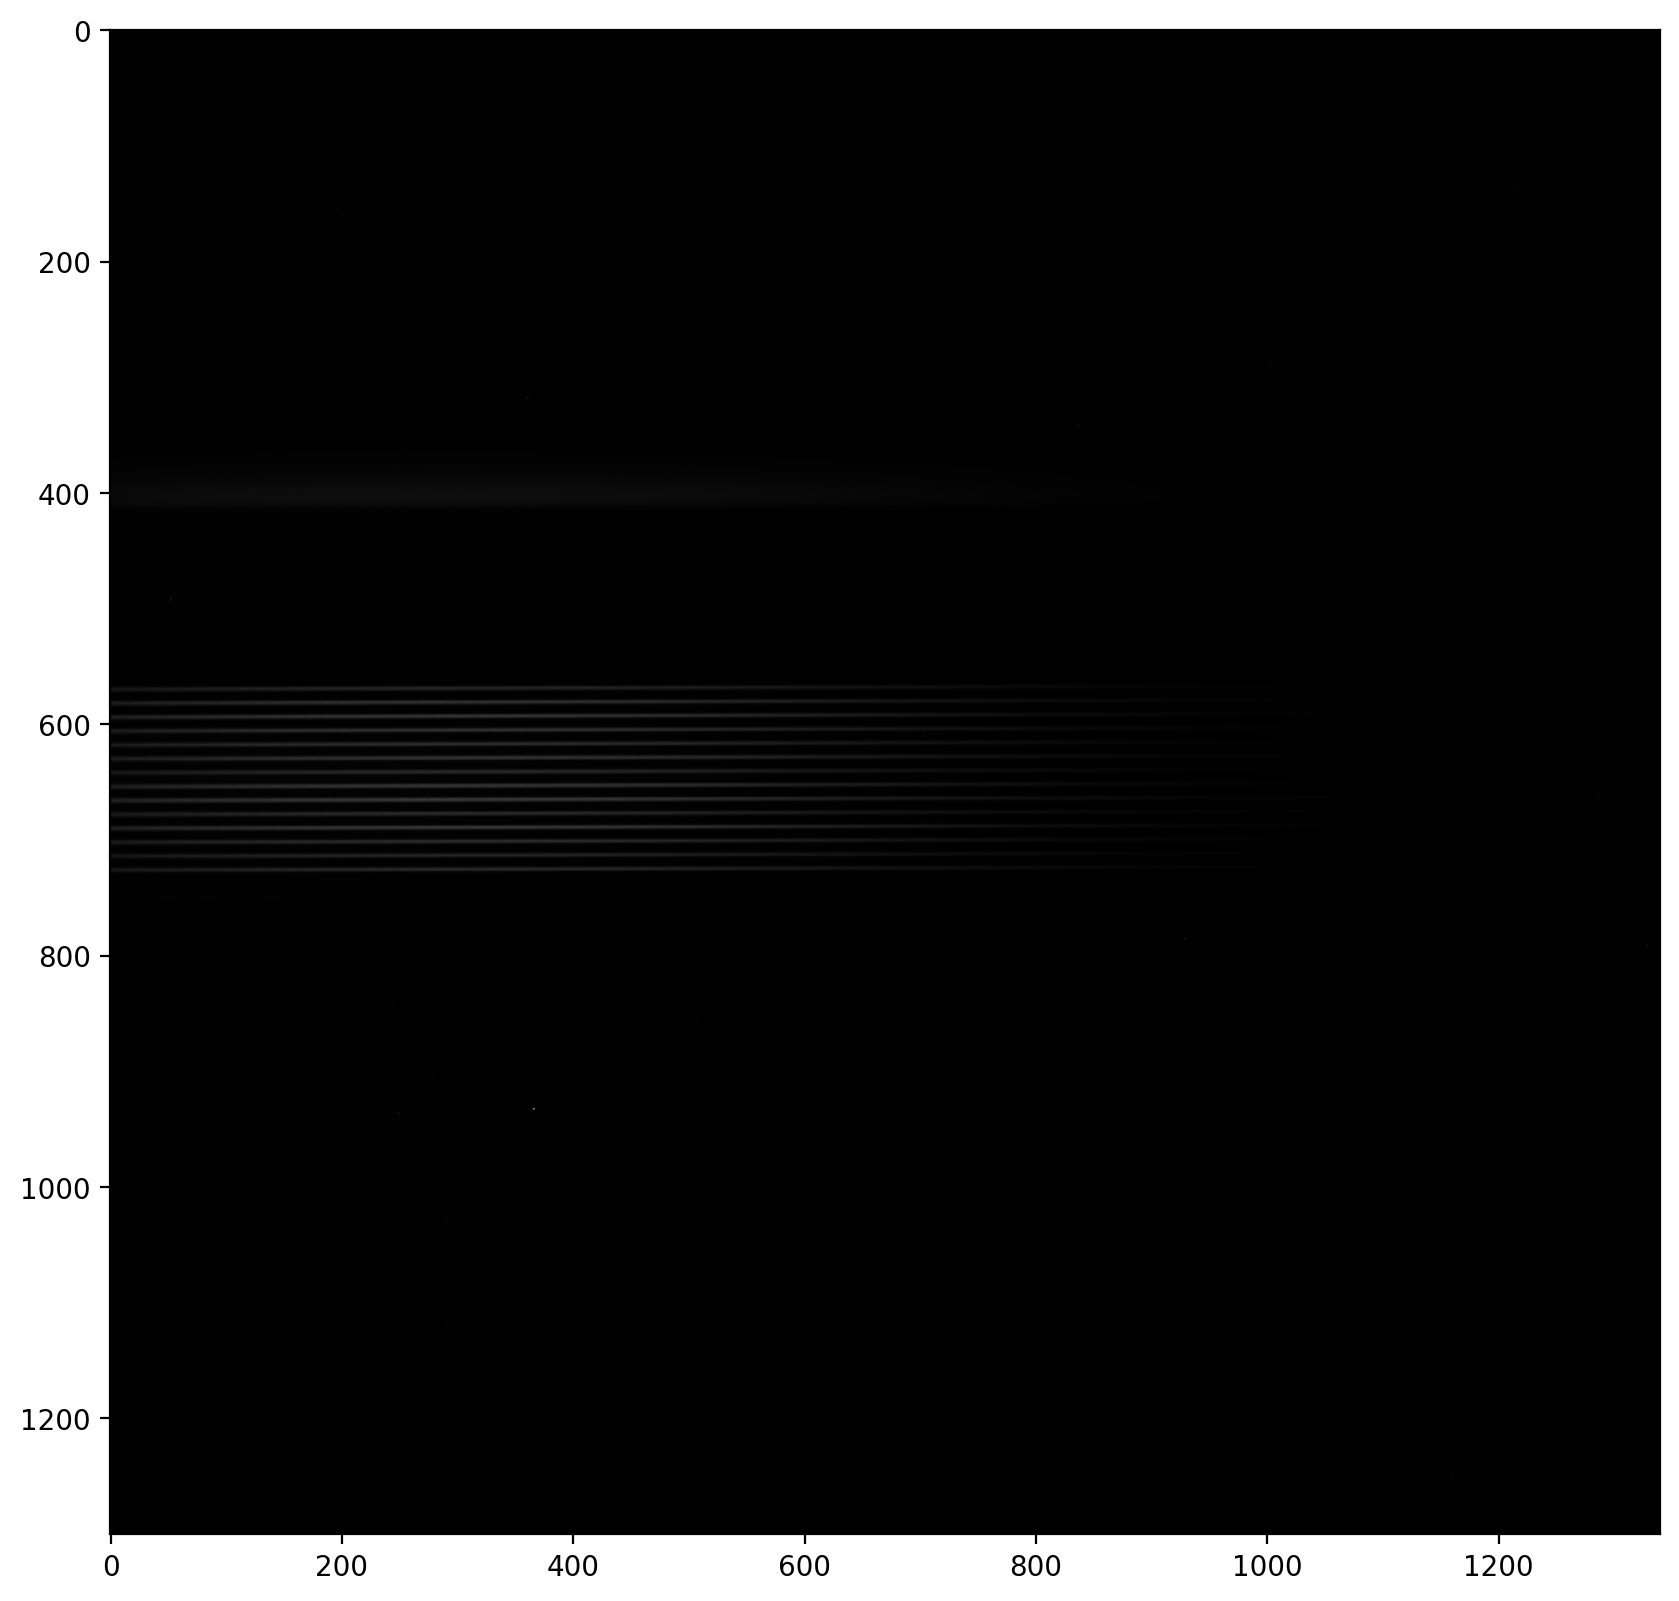

In [8]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(hdul[0].data, cmap="gray")
plt.show()

In [9]:
args = {"IMAGE_FILENAME": new_fpath.as_posix()}

im = ImageFile(new_fpath.as_posix(), mode='READ')
im.open()


make_im(new_fpath.as_posix(),
        cosmic_ray_method='NONE',
        bias_filename=mbias_path.as_posix(),
        use_bias=True,
        verbose=False)

2026-01-22 00:59:02,884 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001.fits (mode: READ)
2026-01-22 00:59:02,885 | kspecdr.preproc.make_im | INFO | Creating IM file from raw data with TDFIO_CREATEBYCOPY functionality...
2026-01-22 00:59:02,885 | kspecdr.preproc.make_im | INFO | Creating IM file from raw file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001.fits -> /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits
2026-01-22 00:59:02,890 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001.fits (mode: READ)
2026-01-22 00:59:02,891 | kspecdr.preproc.make_im | INFO | Instrument: ISOPLANE, SPECTID: UNKNOWN, CLASS: , BITPIX: 16
2026-01-22 00:59:02,892 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001.fits
2026-01-22 0

2026-01-22 00:59:03,158 | kspecdr.preproc.make_im | INFO | Variance HDU created and initialized
2026-01-22 00:59:03,217 | kspecdr.io.image | INFO | Closed file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits


'/data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits'

In [13]:
fpath_im = new_fpath.parent / (new_fpath.stem + "_im.fits")
args = {"IMAGE_FILENAME": fpath_im.as_posix()}

im = ImageFile(fpath_im.as_posix(), mode='READ')
im.open()
img_data, var_data, fibre_types = read_instrument_data(im, 99)

2026-01-22 01:00:14,848 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits (mode: READ)


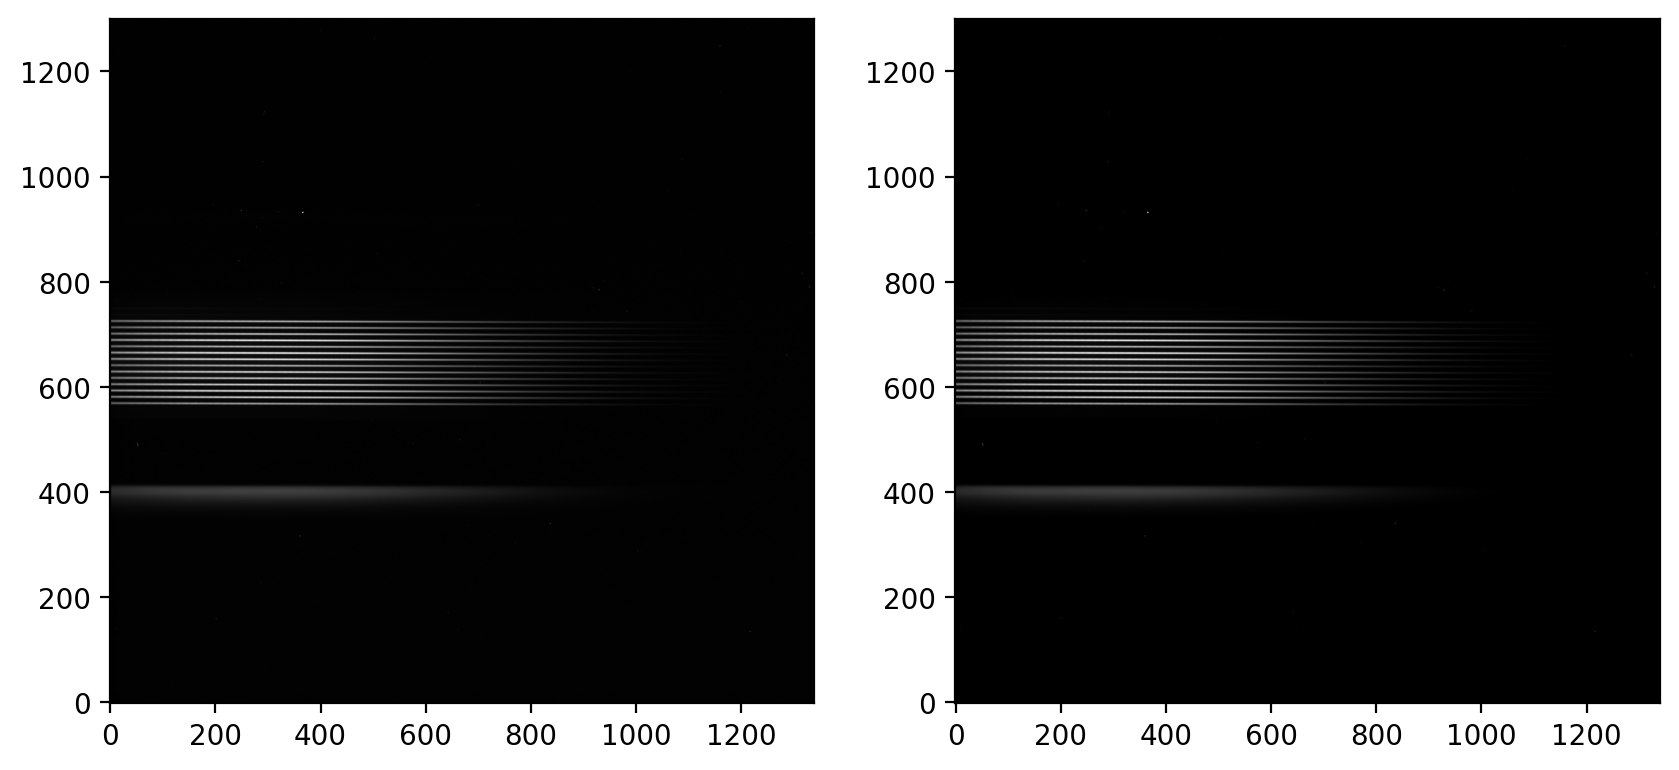

(1300, 1340)
(1300, 1340)


In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(img_data, cmap='gray', origin='lower')
axes[1].imshow(var_data, cmap='gray', origin='lower')
plt.show()
print(img_data.shape)
print(var_data.shape)

In [12]:
logging.getLogger("kspecdr.tlm.make_tlm").setLevel(logging.DEBUG)
make_tlm(args)

2026-01-22 00:59:54,843 | kspecdr.tlm.make_tlm | INFO | Generating tramline map from /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits
2026-01-22 00:59:54,846 | kspecdr.io.image | INFO | Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_im.fits (mode: READ)
2026-01-22 00:59:54,847 | kspecdr.tlm.make_tlm | INFO | Instrument code: 99
2026-01-22 00:59:54,847 | kspecdr.tlm.make_tlm | INFO | Starting tramline map generation for non-2DF instrument
2026-01-22 00:59:54,851 | kspecdr.tlm.make_tlm | INFO | Fibres officially in use: 16
2026-01-22 00:59:54,852 | kspecdr.tlm.make_tlm | INFO | Fibres potentially able: 0
2026-01-22 00:59:54,852 | kspecdr.tlm.make_tlm | INFO | Fibres officially dead: 0
2026-01-22 00:59:54,852 | kspecdr.tlm.make_tlm | INFO | Max number of traces: 16
2026-01-22 00:59:54,852 | kspecdr.tlm.make_tlm | INFO | Image dimensions: nspec=1300, nspat=1340
2026-01-22 00:59:54,853 | kspecdr.tlm.make_tlm 

2026-01-22 00:59:54,870 | kspecdr.tlm.make_tlm | INFO | Processing column 300/1300 (23.1%)
2026-01-22 00:59:54,872 | kspecdr.tlm.make_tlm | INFO | Processing column 350/1300 (26.9%)
2026-01-22 00:59:54,873 | kspecdr.tlm.make_tlm | INFO | Processing column 400/1300 (30.8%)
2026-01-22 00:59:54,875 | kspecdr.tlm.make_tlm | INFO | Processing column 450/1300 (34.6%)
2026-01-22 00:59:54,876 | kspecdr.tlm.make_tlm | INFO | Processing column 500/1300 (38.5%)
2026-01-22 00:59:54,878 | kspecdr.tlm.make_tlm | INFO | Processing column 550/1300 (42.3%)
2026-01-22 00:59:54,879 | kspecdr.tlm.make_tlm | INFO | Processing column 600/1300 (46.2%)
2026-01-22 00:59:54,882 | kspecdr.tlm.make_tlm | INFO | Processing column 650/1300 (50.0%)
2026-01-22 00:59:54,884 | kspecdr.tlm.make_tlm | INFO | Processing column 700/1300 (53.8%)
2026-01-22 00:59:54,886 | kspecdr.tlm.make_tlm | INFO | Processing column 750/1300 (57.7%)
2026-01-22 00:59:54,888 | kspecdr.tlm.make_tlm | INFO | Processing column 800/1300 (61.5%)

In [20]:
fpath_tlm = new_fpath.parent / (new_fpath.stem + "_tlm.fits")

tlm = ImageFile(fpath_tlm.as_posix(), mode='READ')
tlm.open()
print(tlm.get_size())

hdul = fits.open(fpath_tlm)
tlm_data = hdul[0].data
print(tlm_data.shape)
hdul.info()

INFO:kspecdr.io.image:Opened file: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_tlm.fits (mode: READ)
(1340, 16)
(16, 1340)
Filename: /data1/hbahk/kspec/kspecdr/resources/isoplane_commissioning/260119/cflat_00001_tlm.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   (1340, 16)   float64   
  1  WAVELA        1 ImageHDU         8   (1340, 16)   float64   


In [23]:
tlm_data

array([[569.16804162, 569.16506736, 569.16209349, ..., 565.54506656,
        565.54262166, 565.54017716],
       [701.55076923, 701.54818462, 701.5456    , ..., 698.09513846,
        698.09255385, 698.08996923],
       [713.55076923, 713.54818462, 713.5456    , ..., 710.09513846,
        710.09255385, 710.08996923],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]], shape=(16, 1340), dtype='>f8')

(0.0, 300.0)

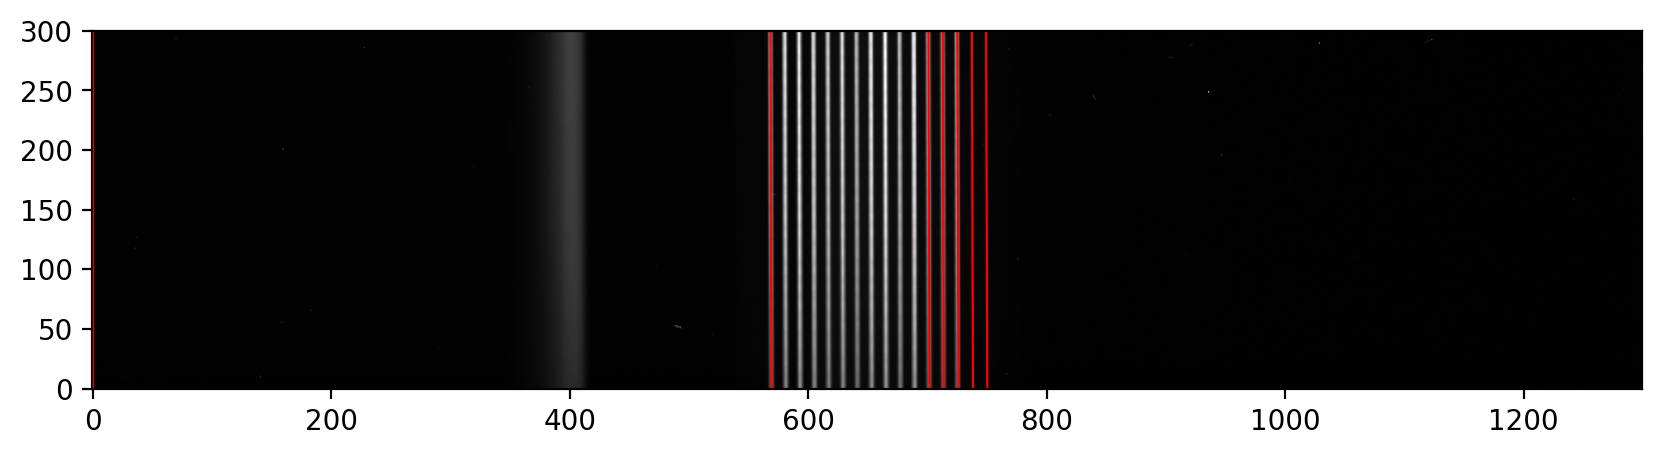

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img_data, cmap='gray', origin='lower')
for tl in tlm_data:
    ax.plot(tl, np.arange(tl.shape[0]), c="r", lw=0.8)

# ax.set_xlim(550, 770)
ax.set_ylim(0, 300)
# ax.set_ylim(1000, 1200)